In [1]:
import os
import random
from utils import initialize_model, load_dataset, split_data, train_client, aggregate_models, set_adapters, save_global_model, get_adapters
import warnings
import torch
import hashlib
import numpy as np
import os
import pandas as pd
from datasets import Dataset, DatasetDict
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments, Trainer
from peft import LoraConfig, get_peft_model, PeftModel
import json
import random
from typing import List, Tuple
from datasets import Dataset
import copy
warnings.filterwarnings("ignore")

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

SIM_NAME = 'returning_model_loading'
NUM_ROUNDS = 20
NUM_CLIENTS = 20
CLIENT_FRAC = 0.1
MODEL_NAME = 'HuggingFaceTB/SmolLM-360M'
path = '../.dataset/hdfs/tokenized'

/home/gabriel.talasso/log_ad_llm_fl/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
global_model, tokenizer = initialize_model(MODEL_NAME, lora_rank=8, sim_name=SIM_NAME)
rs = random.SystemRandom()
tokenized_datasets = load_dataset(path, nrows=100000)
clients_datasets, clients_datasets_eval = split_data(tokenized_datasets, NUM_CLIENTS)

#remove "text" columns from all datasets
for i in range(NUM_CLIENTS):
    clients_datasets[i] = clients_datasets[i].remove_columns("text")
    clients_datasets_eval[i] = clients_datasets_eval[i].remove_columns("text")

Map: 100%|██████████| 100000/100000 [00:27<00:00, 3687.92 examples/s]


In [4]:
round = 1

In [47]:
#Select Clients
clients = rs.sample(list(range(NUM_CLIENTS)), int(NUM_CLIENTS*CLIENT_FRAC))

print(f"Round {round}: Clients Selected {clients}")

# Train clients
clients_models = []
for client in clients:
    client_model = train_client(int(client), clients_datasets[client], global_model, round, SIM_NAME, tokenizer, max_steps=1)
    clients_models.append(client_model)
    print(f"Round {round}: Client {client} trained")

Round 1: Clients Selected [4, 11]


max_steps is given, it will override any value given in num_train_epochs


Step,Training Loss,Validation Loss


Round 1: Client 4 trained


max_steps is given, it will override any value given in num_train_epochs


Step,Training Loss,Validation Loss


Round 1: Client 11 trained


In [48]:
layer = 'base_model.model.model.layers.0.self_attn.q_proj.base_layer.weight'
print(clients_models[0].state_dict()[layer])
print(clients_models[1].state_dict()[layer])
print(global_model.state_dict()[layer])

tensor([[ 0.0014, -0.0128, -0.0179,  ..., -0.0038,  0.0056, -0.0038],
        [ 0.0014, -0.0056,  0.0065,  ..., -0.0125, -0.0088, -0.0075],
        [-0.0038, -0.0028, -0.0052,  ...,  0.0071,  0.0039,  0.0123],
        ...,
        [-0.0015,  0.0204, -0.0107,  ..., -0.0037,  0.0040,  0.0073],
        [-0.0014,  0.0205, -0.0099,  ..., -0.0029,  0.0051,  0.0101],
        [-0.0459, -0.0410, -0.0034,  ...,  0.0087, -0.0378, -0.0464]],
       device='cuda:0')
tensor([[ 0.0014, -0.0128, -0.0179,  ..., -0.0038,  0.0056, -0.0038],
        [ 0.0014, -0.0056,  0.0065,  ..., -0.0125, -0.0088, -0.0075],
        [-0.0038, -0.0028, -0.0052,  ...,  0.0071,  0.0039,  0.0123],
        ...,
        [-0.0015,  0.0204, -0.0107,  ..., -0.0037,  0.0040,  0.0073],
        [-0.0014,  0.0205, -0.0099,  ..., -0.0029,  0.0051,  0.0101],
        [-0.0459, -0.0410, -0.0034,  ...,  0.0087, -0.0378, -0.0464]],
       device='cuda:0')
tensor([[ 0.0014, -0.0128, -0.0179,  ..., -0.0038,  0.0056, -0.0038],
        [ 0.00

In [24]:
get_adapters(clients_models[0]base_model.model.model.layers.0.self_attn.q_proj.lora_B.default.weight)[0]

tensor([-0.0008, -0.0011,  0.0007,  0.0015,  0.0014,  0.0015, -0.0015,  0.0012],
       device='cuda:0')

In [25]:
get_adapters(clients_models[1])["base_model.model.model.layers.0.self_attn.q_proj.lora_B.default.weight"][0]

tensor([ 0.0003,  0.0005,  0.0010,  0.0013,  0.0012,  0.0016, -0.0014,  0.0003],
       device='cuda:0')

In [26]:
get_adapters(global_model)["base_model.model.model.layers.0.self_attn.q_proj.lora_B.default.weight"][0]

tensor([ 0.0008,  0.0003,  0.0011,  0.0014,  0.0011,  0.0016, -0.0014,  0.0010])

In [27]:
# Aggregate model
aggregated_adapters = aggregate_models(clients_models)

In [28]:
aggregated_adapters["base_model.model.model.layers.0.self_attn.q_proj.lora_B.default.weight"][0]

tensor([-0.0003, -0.0003,  0.0008,  0.0014,  0.0013,  0.0016, -0.0014,  0.0008],
       device='cuda:0')

In [21]:
set_adapters(global_model, aggregated_adapters)

In [32]:
save_global_model(global_model, round, SIM_NAME)

In [33]:
epochs=1
batch_size=32
max_steps=1
client_id = 0


model = AutoModelForCausalLM.from_pretrained('HuggingFaceTB/SmolLM-360M')
model = PeftModel.from_pretrained(model, f'fl-results/{SIM_NAME}/round_{round-1}/global_model', is_trainable=True)

In [34]:
get_adapters(model)["base_model.model.model.layers.0.self_attn.q_proj.lora_B.default.weight"][0]

tensor([ 0.0008,  0.0003,  0.0011,  0.0014,  0.0011,  0.0016, -0.0014,  0.0010])

In [15]:
# Define Training Arguments
training_args = TrainingArguments(
    output_dir="./fl-results",
    logging_dir="./logs",
    logging_steps=100,
    learning_rate=2e-5,
    max_steps=max_steps,
    num_train_epochs=epochs,
    weight_decay=0.01,
    per_device_train_batch_size=batch_size,
    save_steps=1000,
    evaluation_strategy="steps",
    eval_steps=max_steps+1, 
)

In [16]:
class CustomTrainer(Trainer):
    def __init__(self, client, **kwargs):
        super().__init__(**kwargs)
        self.train_losses = {}
        self.validation_losses = {}
        self.client = client

    def log(self, logs):
        # Save client losses
        super().log(logs)
        if "loss" in logs:
            self.train_losses[client] = float(logs["loss"])
        if "eval_loss" in logs:
            self.validation_losses[client] = float(logs["eval_loss"])

trainer = CustomTrainer(client=client,
                        model=model,
                        args=training_args,
                        train_dataset=clients_datasets[client_id],
                        eval_dataset=clients_datasets_eval[client_id])

max_steps is given, it will override any value given in num_train_epochs


In [17]:
get_adapters(trainer.model)["base_model.model.model.layers.0.self_attn.q_proj.lora_B.default.weight"][0]

tensor([0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')

In [18]:
trainer.train()

Step,Training Loss,Validation Loss


TrainOutput(global_step=1, training_loss=1.6342928409576416, metrics={'train_runtime': 2.2872, 'train_samples_per_second': 13.991, 'train_steps_per_second': 0.437, 'total_flos': 31010429337600.0, 'train_loss': 1.6342928409576416, 'epoch': 0.1})

In [54]:
get_adapters(trainer.model)["base_model.model.model.layers.0.self_attn.q_proj.lora_B.default.weight"][0]

tensor([ 1.2045e-05,  6.9064e-06, -2.7410e-05,  2.9566e-05, -1.2492e-05,
        -2.4802e-05,  3.0794e-05,  2.1151e-05], device='cuda:0')

In [55]:
get_adapters(model)["base_model.model.model.layers.0.self_attn.q_proj.lora_B.default.weight"][0]

tensor([ 1.2045e-05,  6.9064e-06, -2.7410e-05,  2.9566e-05, -1.2492e-05,
        -2.4802e-05,  3.0794e-05,  2.1151e-05], device='cuda:0')

In [ ]:
# Save model
output_dir = f"./fl-results/{SIM_NAME}/round_{round}/client_{client}"
os.makedirs(output_dir, exist_ok=True)
model.save_pretrained(output_dir)

# Save losses
with open(f"{output_dir}/training_losses.json", "w") as f:
    json.dump(trainer.train_losses, f)

with open(f"{output_dir}/validation_losses.json", "w") as f:
    json.dump(trainer.validation_losses, f)

In [2]:
import math

In [14]:
def cosine_learning_rate(current_round, total_rounds, initial_lr=0.001, min_lr=0):
    """
    Compute the learning rate based on a cosine schedule.

    :param current_round: The current training round (0-indexed).
    :param total_rounds: The total number of training rounds.
    :param initial_lr: The initial learning rate.
    :param min_lr: The minimum learning rate.
    :return: The computed learning rate for the current round.
    """
    # Compute the cosine learning rate
    cosine_lr = min_lr + 0.5 * (initial_lr - min_lr) * (1 + math.cos(math.pi * current_round / (1.5*total_rounds)))
    return cosine_lr

<Axes: >

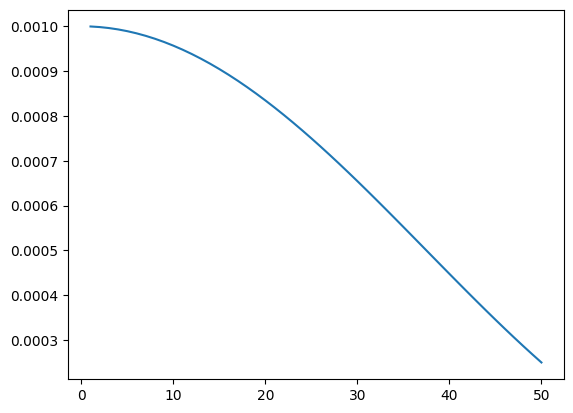

In [15]:
NUM_ROUNDS = 50
lrs = []
for r in range(1, NUM_ROUNDS + 1):
    # Compute the learning rate for the current round
    lr = cosine_learning_rate(r, NUM_ROUNDS, initial_lr=0.001, min_lr=0)
    lrs.append(lr)

import matplotlib.pyplot as plt
import seaborn as sns

sns.lineplot(x=range(1, NUM_ROUNDS + 1), y=lrs)
